In [1]:
#%%
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
import torch.nn as nn
import os
import random
import numpy as np

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [3]:

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

def pdb_checking():
    import pdb
    pdb.set_trace()
    return 0

In [4]:
#%%

from torchvision import datasets
from collections import defaultdict, deque
import itertools

import numpy as np

import random

In [5]:
#%% Method 1
class Cifar5000(datasets.CIFAR10):
    def __init__(self, path, transforms, train=True, label_S = list(range(0,9))):
        super().__init__(path, train, download=False)
        self.transforms = transforms
        self.n_images_per_class = 5000
        self.n_classes = 10
        self.labels = label_S
        self.cifar10 =  datasets.CIFAR10(path, train=train, download=True)


    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, index):
        index = random.randint(0, self.__len__()-1)
        im, label = self.cifar10[index]

        while label not in self.labels: 
            index = random.randint(0, self.__len__()-1)
            im, label = self.cifar10[index]

        if self.transforms:    
            im = self.transforms(im)

        return im, label
    
    
    #%% Method 1
class Cifar5000_ul(datasets.CIFAR10):
    def __init__(self, path, transforms, train=True, label_S = list(range(0,9))):
        super().__init__(path, train, download=False)
        self.transforms = transforms
        self.n_images_per_class = 5000
        self.n_classes = 10
        self.labels = label_S
        self.cifar10 =  datasets.CIFAR10(path, train=train, download=True)


    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, index):
        c_i = random.sample(self.labels, 1)
        index = random.randint(0, self.__len__()-1)
        im, label = self.cifar10[index]

        while label not in c_i:
            c_i = random.sample(self.labels, 1)
            index = random.randint(0, self.__len__()-1)
            im, label = self.cifar10[index]

        if self.transforms:    
            im = self.transforms(im)
        return im, label


def Fdata_loader_C10(label_s = [0,1,2,3,4,8,9],unlabel_s = [5,6,7], batch_size = 32):
    tr_data_l =  Cifar5000(path = "../data", transforms= transform,
                              label_S = label_s)
    tr_data_u =  Cifar5000_ul(path = "../data", transforms= transform,
                              label_S = unlabel_s)
    test_data =  Cifar5000(path = "../data", train= False, transforms= transform,
                              label_S = label_s)
    loader_l = DataLoader(tr_data_l, batch_size=batch_size,
                                               shuffle=True, num_workers=0)
    loader_u = DataLoader(tr_data_u, batch_size=batch_size,
                                               shuffle=True, num_workers=0)
    val_loader = DataLoader(test_data, batch_size=batch_size,
                                               shuffle=True, num_workers=0,
                                               drop_last=True)    
    return loader_l, loader_u, val_loader




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


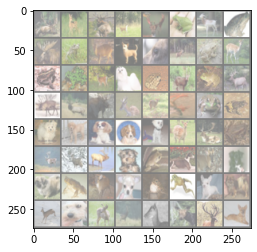

deer  deer  deer  deer  deer  frog  deer  frog  deer  frog  deer  dog   deer  deer  frog  deer  frog  frog  deer  dog   frog  deer  frog  deer  deer  deer  deer  deer  deer  deer  frog  frog  dog   dog   dog   dog   dog   deer  deer  frog  deer  deer  deer  dog   frog  dog   deer  dog   dog   frog  deer  dog   frog  frog  dog   dog   deer  dog   deer  deer  deer  deer  deer  dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

batch_size = 64
_, tr_loader_l, _ = Fdata_loader_C10(label_s= [0,1,2,3, 7,8,9],unlabel_s=[4,4,5,6], batch_size=batch_size,)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(tr_loader_l)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#sum(labels == 1)


In [6]:
#%% Augmentation Set
data_norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
Aug_Set = [transforms.Compose([transforms.Resize((32,32)), data_norm]),
    transforms.Compose([transforms.RandomHorizontalFlip(p = 1), data_norm]),# FLips the image w.r.t horizontal axis
    transforms.Compose([transforms.RandomVerticalFlip(p = 1),data_norm]),# FLips the image w.r.t vertical axis
    transforms.Compose([transforms.RandomRotation(10),   data_norm]),  #Rotates the image to a specified angel
    transforms.Compose([transforms.GaussianBlur(kernel_size= 3, sigma=(0.2, 1)), data_norm]), # gaussian noise addition
    transforms.Compose([transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),data_norm]), #Performs actions like zooms, change shear angles.
    transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), data_norm]),
    transforms.Compose([transforms.CenterCrop(25), transforms.Resize((32,32)), data_norm ])]

#### getting all the augmented images in single line.
# imf_long = list(map(lambda Aug_Set: Aug_Set(images), Aug_Set))

#### Getting all images togehter

# start_idx = 0
# idx_crops =  len(Aug_set)
# for end_idx in idx_crops:
#     _out = torch.cat(imf_long[start_idx: end_idx])
#     if start_idx == 0:
#         output = _out
#     else:
#         output = torch.cat((output, _out))
#     start_idx = end_idx



In [7]:
#%% Import Model
import cifar10_model
import importlib
importlib.reload(cifar10_model)
from cifar10_model import Net, MobileNetV2, resnet18, HypersphericalProto

In [8]:
#%%

net1 = MobileNetV2()


ptn = nn.functional.normalize(torch.randn((10,100)))

net = HypersphericalProto(net1,  10, ptn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

import torch.optim as optim


In [9]:
#%% Loss functions

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0009, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.0009)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)



sm = nn.Softmax(dim= 1)
import pdb
def neg_loss(ip, SS, tau = 1):
    yn = sm(ip/tau)
    # nl = torch.zeros(1,ip.shape[1], dtype= torch.float32)
    # nl[0][SS] = torch.tensor(1.0)
    # return -torch.sum(torch.mm(nl.cuda(),torch.log(1.0 - yn +1*10**-5).t()))
    return -torch.log(1 - yn[:,SS] + 1*10**-10).mean()


def entropy_loss(ip, US):
    yn = sm(ip[:, US]).cuda()
    return -torch.mean(torch.sum(yn*torch.log(yn + 1*10**-8), axis = 1))

import torch.nn.functional as F
class HLoss(nn.Module):
    def __init__(self, tau = 0.5):
        super(HLoss, self).__init__()
        self.tau = tau

    def forward(self, x):
        b = F.softmax(x/self.tau, dim=1) * F.log_softmax(x/self.tau, dim=1)
        b = -1.0 * b.sum(dim = 1)
        return b.mean()

def var_loss(ip, US):
    yn = sm(ip[:, US]/1).cuda()
    obj_var = (yn.shape[1] -1)/yn.shape[1]**2
    var_v= yn.var(0)
    return torch.mean((obj_var - var_v)**2)

#     return torch.sum(torch.square(var_v - obj_var)

KLD = torch.nn.KLDivLoss(log_target = True).cuda()


kl_loss = nn.KLDivLoss(reduction="batchmean")
def kl_loss_ul(ip, tau =0.5, US = None, targ_ = None):
    yn = sm(ip/tau)
    pp =  yn.mean(dim = 0)
    if targ_ is None:
        targ_ =  torch.zeros(pp.shape)
#         targ_[US] = 1/len(US)
        targ_[US] = 1
        return -torch.mean(targ_[US].cuda()*torch.log((1-F.relu(1-pp[US]*len(US)) + 1*10**-10).cuda()))
    
    return  -torch.mean(torch.log((1-F.relu(1-pp[US]/torch.tensor(targ_[US]).clone().detach().cuda()) + 1*10**-10).cuda()))
#     return -torch.mean(targ_[US].cuda()*torch.log((pp[US] + 1*10**-10)/(targ_[US]+1*10**-10).cuda()))
    
#     return -torch.mean(targ_[US].cuda()*torch.log((1-F.relu(1-pp[US]*len(US)) + 1*10**-10).cuda()))





#     return kl_loss(torch.log(pp+10**-20).cuda(), targ_.cuda())
    
    # yn = sm(ip[:, US])
    # return KLD(torch.log(targ_).cuda(), torch.log(pp).cuda())

    # return criterion(F.relu(ip).sum(dim =0), targ_.cuda()) # a relu to avoid any negative helping
    # return torch.sum((targ_.cuda()- pp)**2)
    # return  F.relu(targ_[US].cuda() -pp[US]).sum()*5
# Distance wise loss  F.relu(targ_ -pp).mean()


def kl_loss_uf_full(ip, US, targ_ =  None):
    yn = ip
    pp = yn.mean(0)
    if targ_ is None:
        targ_ =  torch.zeros(pp.shape)
        targ_[US] = 1/len(US)
    # return KLD(torch.log(targ_).cuda(), torch.log(pp).cuda())
    return None # use proper KLD loss / JS loss

def norm_loss(m1, m2):
#     m2 = sm(m2/0.1)
    
#     return criterion(m1, cuda(), m2.cuda())
    return criterion(m1.cuda(), m2.cuda())
    #return torch.norm(m1 -m2)

#mse loss (norm alternative)
l_mse = nn.MSELoss()
def norm_loss2(m1, target):
    m1 = sm(m1)
    target = sm(target)
    return l_mse(m1.cuda(), target.cuda())
    
def mul_var_loss(ip, tau = 0.5, US = None, targ_ =  None):
    yn = sm(ip[:,US]/tau)
    pp =  yn.var(dim = 0)
    if targ_ is None:
        targ_ =  torch.zeros(pp.shape)
        targ_[US] = 1/len(US)
        
    targ_ = targ_[US]*(1-targ_[US])
    return l_mse(pp.cuda()/tau, targ_.cuda()/tau)

def neg_loss2(ip, US):
    yn= sm(ip)
    v_sum = torch.relu(1-torch.sum(yn[:,US], axis=1)).cuda()
    return torch.mean(v_sum)


In [10]:
#%% Training Loop
entropy_c = HLoss(tau=0.5)
#  https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/7

batch_size = 128

temp_ = 0.1

def train_joint(net, data_, label_, data_u, SS = None, US = None, targ_ = None, lab_u = None):
            batch_size = data_.shape[0]
            tau =  1
            optimizer.zero_grad()
            
            out_ = net(torch.cat([data_, data_u], dim =0))/temp_
        
            outputs = out_[0:batch_size]
            outputs_u= out_[batch_size:]
            
#             dist_loss_s = kl_loss_ul(outputs, tau, US = SS, targ_ = None)
            
#             n_loss_s = neg_loss(outputs, US)
#             n_loss = neg_loss(outputs_u, SS)
            
            # clustering losses

#             v_loss = mul_var_loss(outputs_u, tau = 1, US= US, targ_ = targ_)
            e_loss = entropy_c(outputs_u[:, US])
            dist_loss = kl_loss_ul(outputs_u, tau, US = US, targ_ = targ_)
            
#             u_targs_ =  torch.as_tensor(US)[outputs_u[:, US].detach().clone().argmax(dim = 1).tolist()]
#             full_loss = criterion(outputs_u, u_targs_.cuda())
          
            # supervised losses
            loss_s1 = criterion(outputs/tau, label_)
#             n_loss_s = neg_loss(outputs, US)

            loss_s = loss_s1 + e_loss+dist_loss #+ dist_loss_s   # + v_loss + 0.1*full_loss + 0.01*(n_loss_s+ n_loss)
            

            if torch.sum(torch.isnan(loss_s1))>0: pdb.set_trace() #loss_s.isnan().any()
            loss_s.backward()
            optimizer.step()
            
#             pdb.set_trace()
            return None

def train_label(net, data_, label_, data_1= None, SS = None, US = None, targ_ = None):
            batch_size = data_.shape[0]
            tau = 1
            optimizer.zero_grad()
            
            if data_1 is not None:
                out_= net(torch.cat([data_,data_1], dim = 0))/temp_   
                loss_s = criterion(out_/tau, torch.cat([label_, label_], dim = 0))

            else:
                outputs = net(data_)/temp_
            
            # supervised losses
                loss_s = criterion(outputs/tau, label_)
        

#             n_loss_s = neg_loss(outputs, US)
            n_loss_s = None


            

            if torch.sum(torch.isnan(loss_s))>0: pdb.set_trace() #loss_s.isnan().any()
                
            loss_s.backward()
            optimizer.step()
            
#             pdb.set_trace()

            return loss_s, n_loss_s

def train_unlabel(net, data_u, data_u1=None, SS = None, US = None, targ_ = None, lab_u = None):
            tau = 1
            batch_size = data_u.shape[0]
            optimizer.zero_grad()
        
            if data_u1 is not None:
                out_= net(torch.cat([data_u,data_u1], dim = 0))/temp_
                                
                outputs_u= out_[0:batch_size]
                outputs_u1 = out_[batch_size:]
                
                v_loss = mul_var_loss(outputs_u, tau, US= US, targ_ = targ_)
                e_loss = entropy_c(outputs_u[:, US])
                dist_loss = kl_loss_ul(outputs_u, tau, US = US, targ_ = targ_)                     
                
#                 try:
#                     u_targs_ =  torch.as_tensor(US)[outputs_u[:, US].detach().argmax(dim = 1).tolist()]
#                     u_targs_1 =  torch.as_tensor(US)[outputs_u1[:, US].detach().argmax(dim = 1).tolist()]
#                 except:
#                     pdb.set_trace()
                    

#                 full_loss = criterion(outputs_u1, u_targs_.cuda()) + criterion(outputs_u, u_targs_1.cuda())
                v_loss1 = mul_var_loss(outputs_u1, tau, US= US, targ_ = targ_)
                e_loss1 = entropy_c(outputs_u1[:, US])
                dist_loss1 = kl_loss_ul(outputs_u1, tau, US = US, targ_ = targ_)
                full_loss = norm_loss2(outputs_u1, outputs_u.detach().clone()) + norm_loss2(outputs_u, outputs_u1.detach().clone())
                
                loss = dist_loss + 0.01*v_loss  + e_loss + dist_loss1 + 0.01*v_loss1  + e_loss1 + 0.1*full_loss
            
            else:
                
                outputs_u= net(data_u)/temp_
            
            # clustering losses
            #n_loss = neg_loss(outputs_u, SS)
                v_loss = mul_var_loss(outputs_u, tau, US= US, targ_ = targ_)
                e_loss = entropy_c(outputs_u[:, US])
                dist_loss = kl_loss_ul(outputs_u, tau, US = US, targ_ = targ_)
                loss = dist_loss + v_loss  + e_loss # + 0.5*full_loss
            
            # clustering loss final
            
            if torch.sum(torch.isnan(loss))>0: pdb.set_trace()#loss.isnan().any()
            
            loss.backward()
            optimizer.step()
            
#             pdb.set_trace()
            
            return dist_loss, e_loss, v_loss , full_loss
            


        
def train_loop(net, trainloader_l, trainloader_u, epoch_range = 2, SS = None, US = None, targ_ = None):
    for epoch in range(epoch_range):  # loop over the dataset multiple times
        # pdb.set_trace()
        running_loss = 0.0
        for i, (data_l, data_u) in enumerate(zip(trainloader_l, trainloader_u), 0):
            
            # get the inputs; data is a list of [inputs, labels]
            images_, labels = data_l
            images_u_, lab_u = data_u  
            aug_num =  random.sample([_ for _ in range(len(Aug_Set))], 2)
            
            images = Aug_Set[0](images_).to(device)
            
                              
            images_u = Aug_Set[aug_num[0]](images_u_).to(device)
            labels = labels.to(device)
            
            
            net.train()
            
            if i % 5 == 0:
                images1 = Aug_Set[aug_num[1]](images_).to(device)
                images_u1 = Aug_Set[aug_num[1]](images_u_).cuda()
                loss_s1, n_loss_s = train_label(net, images, labels, images1, SS = SS, US= US, targ_ = targ_)
                dist_loss, e_loss, n_loss, f = train_unlabel(net, images_u, images_u1, SS = SS, US = US, targ_ = targ_, lab_u= lab_u)
            else:
                train_joint(net, images, labels, images_u, SS = SS, US= US, targ_ = targ_, lab_u = lab_u)
 
            #running_loss += loss_s1.item()
            if i % 500 == 19:    # print every 500 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss:')
                print(f'sup: {loss_s1} entropy: {e_loss} dist: {dist_loss} {n_loss}' )  
                # print(f'sup: {loss_s}')
                #running_loss = 0.0
        scheduler.step()
        
    print('Finished Training')

In [11]:
#%% Data definition
all_s = [_ for _ in range(10)]
label_s = [0,1,2,3,4]
unlabel_s = [5,6,7,8,9]
u_unlabel_s = list(set(unlabel_s))
u_unlabel_s.sort()
distr = torch.from_numpy(np.array([sum(np.array(unlabel_s)== i) for i in all_s])/len(unlabel_s)).float()

In [12]:
distr

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000])

In [13]:
# data Loader
loader_l, loader_u, val_loader = Fdata_loader_C10(label_s=label_s, unlabel_s= unlabel_s, batch_size = batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
train_loop(net, loader_l, loader_u, epoch_range = 50, SS = label_s, US = u_unlabel_s, targ_ = distr)

/tmp/ipykernel_193/2268002224.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return  -torch.mean(torch.log((1-F.relu(1-pp[US]/torch.tensor(targ_[US]).clone().detach().cuda()) + 1*10**-10).cuda()))


[1,    20] loss:
sup: 2.369596004486084 entropy: 0.24238885939121246 dist: 1.3410993814468384 0.025519026443362236
[2,    20] loss:
sup: 1.8048993349075317 entropy: 0.3295478820800781 dist: 1.3458504676818848 0.02483108825981617
[3,    20] loss:
sup: 1.5811184644699097 entropy: 0.27295997738838196 dist: 1.3989183902740479 0.023960990831255913
[4,    20] loss:
sup: 1.500700831413269 entropy: 0.19973643124103546 dist: 1.5240325927734375 0.023893684148788452
[5,    20] loss:
sup: 1.1353598833084106 entropy: 0.3374037742614746 dist: 1.2528237104415894 0.02310383878648281
[6,    20] loss:
sup: 1.473487377166748 entropy: 0.12568478286266327 dist: 0.888434886932373 0.008603463880717754
[7,    20] loss:
sup: 1.4683917760849 entropy: 0.09757140278816223 dist: 0.44774460792541504 0.0019606424029916525
[8,    20] loss:
sup: 1.4142935276031494 entropy: 0.05415051802992821 dist: 0.2047065943479538 0.0006771109183318913
[9,    20] loss:
sup: 0.8750082850456238 entropy: 0.07534340023994446 dist: 0.37

In [16]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.0009
    lr: 0.0008560850653773281
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [27]:
#%% Supervised setting Training Alternate training loop from dataloader
SupL =  nn.CrossEntropyLoss()

# my_net = net
net.cuda()
def sup_testing_res(criterion, my_net, data_loader):
    j = 0
    
    my_net.train()

    for m in my_net.modules():
        if isinstance(m, nn.BatchNorm2d):
             m.track_running_stats=False

    r_test, r_test_full = [], []
    r_true = []
    
    for s1, s2 in data_loader: 
        s1 =  Aug_Set[0](s1).cuda()
        s2 =  s2.cuda()
        
        
        
        with torch.no_grad():
            output = my_net(s1)
            
        r_test_full.append(output.cpu())
        
        r_test.append(output.argmax(dim = 1).cpu())
        r_true.append(s2.cpu())
        
#         pdb.set_trace()
        
        if j == 100:
            return r_test, r_true, r_test_full
            break
            
        j = j+1
        
    return r_test, r_true, r_test_full
            
        
        
def sup_testing(net, data_loader= None):
    data_loader= data_loader
    
    if data_loader is None:
        data_loader = []; del(data_loader); torch.cuda.empty_cache()
        data_loader ,_ , _ = Fdata_loader_C10(label_s= [_ for _ in range(10)], batch_size=64,)
    r_ts, r_tr, r_ts_f = sup_testing_res(SupL, net, data_loader)
    
    
    r_ts_f = np.array(r_ts_f)
    r_tsnp =  np.array(r_ts)
    r_trnp =  np.array(r_tr)
    for i in range(len(r_ts)):r_trnp[i] = r_trnp[i].numpy();r_tsnp[i] = r_tsnp[i].numpy(); r_ts_f[i] = r_ts_f[i].numpy()
    del(data_loader); torch.cuda.empty_cache()
    r_tsc = np.concatenate(r_tsnp)
    r_trc = np.concatenate(r_trnp)
    r_tfs = np.concatenate(r_ts_f)

    return r_tsc, r_trc, r_tfs
        
r_ts, r_tr, r_tfs = sup_testing(net, data_loader= None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_119/190037779.py:53: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  r_ts_f = np.array(r_ts_f)
/tmp/ipykernel_119/190037779.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r_ts_f = np.array(r_ts_f)
/tmp/ipykernel_119/190037779.py:54: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`

[[ 11 422  65  82  21   7   2   4  15  11]
 [  6  83   8 528   1   1   1   0   6  37]
 [165 102 239  14  48  15  19  17   4   4]
 [311  38 153   9  18  53  15  21   4  15]
 [ 13   7   5   0 622   4   1   2   1   0]
 [ 15   0   6   0   6 646   1   4   0   1]
 [ 19   2   5   1   4   1 593   0   1   0]
 [  8   1   3   0  10   1   0 611   0   1]
 [  0  11   4  14   1   0   1   0 624   1]
 [  1   1   1   4   0   1   1   0   1 628]]


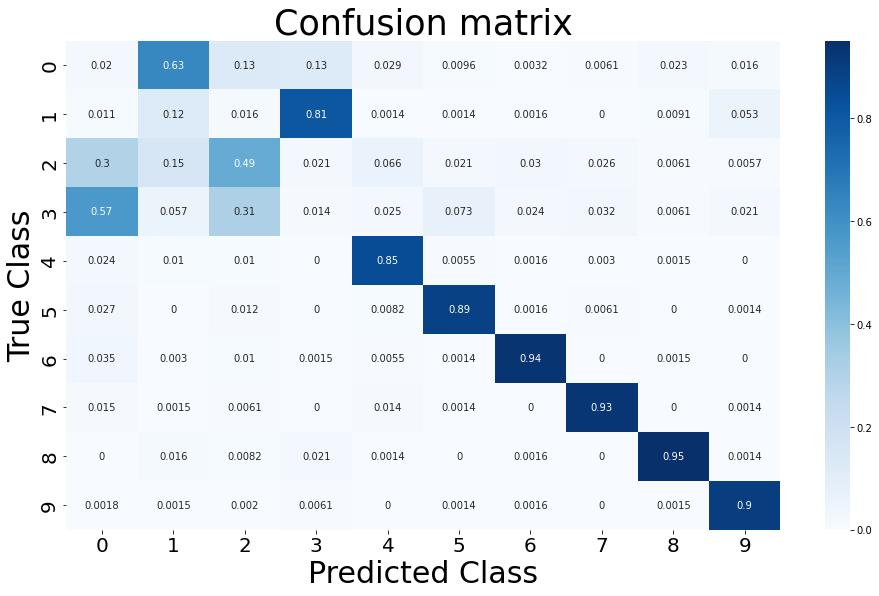

In [25]:
#%%
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
# import pandas as pd
def conf_plot(r_ts, r_tr):
    # labs = list(LabelDict.keys())
    cf_matrix = confusion_matrix(r_tr, r_ts)
    print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix/((np.sum(cf_matrix, axis = 0))), index = [i for i in [0,1,2,3,4,5,6,7,8,9]],
                           columns = [i for i in [0,1,2,3,4,5,6,7,8,9]])
    plt.figure(figsize = (16,9))
    # fig.savefig("camera_info_sf_adv.svg", dpi=500, format='svg', metadata=None)
#     sn.heatmap(, annot=True)
    
    s = sn.heatmap(df_cm, annot=True, cmap='Blues')
    sn.set(font_scale=1.5)
    s.set_title('Confusion matrix', fontsize = 35)
    s.set_xlabel('Predicted Class', fontsize=30)
    s.set_ylabel('True Class', fontsize=30)
    
    plt.savefig("confusion_matrix.svg", dpi=500, format='svg', metadata=None)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

    
    
conf_plot(r_ts, r_tr)

In [24]:
# pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 293 kB 5.7 MB/s            
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [20]:
testloader ,_ , _= Fdata_loader_C10(label_s= [0,1,2,3,4], batch_size=32,)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


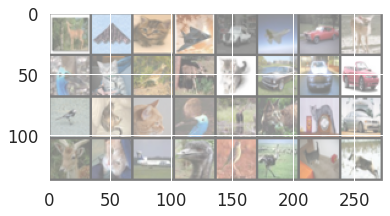

GroundTruth:  deer  plane cat   plane


In [21]:
import matplotlib.pyplot as plt
# print images

dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [32]:
device = 'cuda'
model = net

import pdb
def embed_test(val_loader, model):
    data_t =[] 
    data_lab = []
    
    model.train()
    with torch.no_grad():
        for images, labels in val_loader:
            images = Aug_Set[0](images).to(device)
            labels = labels.to(device)
            output= model(images)
            # output = activation['fc2']

            data_t.append(output.cpu().numpy())
            data_lab.append(labels.cpu())
    return data_t, data_lab

data_loader, _, val_loader = Fdata_loader_C10(label_s=[0,1,2,3,4,5,6,7,8,9], unlabel_s= unlabel_s, batch_size = batch_size)
data_t, data_lab = embed_test(data_loader, net)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.005s...
[t-SNE] Computed neighbors for 6400 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.120960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.040665
[t-SNE] KL divergence after 1000 iterations: 1.346776


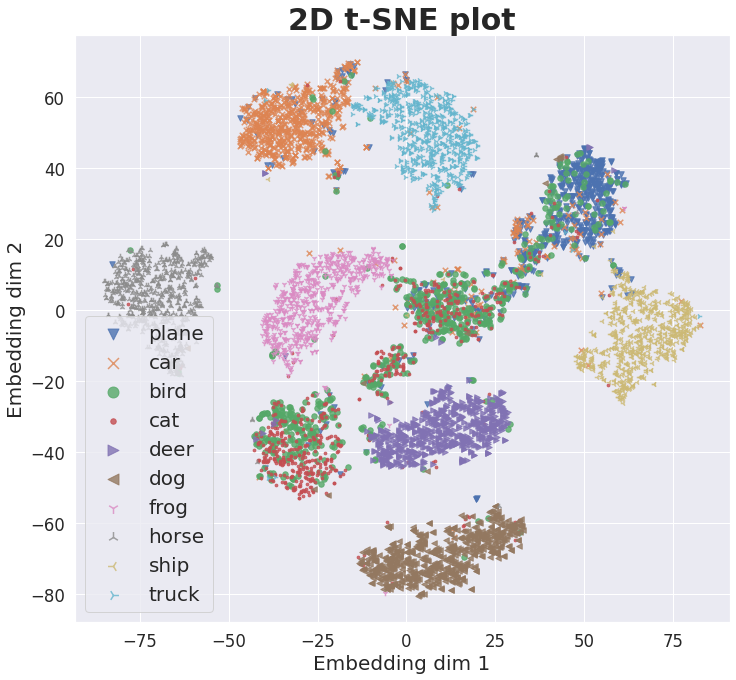

In [33]:
#%% Ploting TSNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

import sklearn
import sklearn.cluster as clusters

def tsne_plot(data = data_t, label1 = data_lab, n_comp = 2 ):
    
    
    X_embedded = TSNE(n_components=n_comp, verbose=1).fit_transform(data)

    
#     new_data = clusters.KMeans(n_clusters=4).fit(data)
#     print(sklearn.metrics.silhouette_score(data, new_data.labels_))

    # print(sklearn.metrics.silhouette_score(data, label1))
    

    fig = plt.figure(figsize=(19.20,10.80))
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
    
    markers = ['v', 'x', 'o', '.', '>', '<', '1', '2', '3', '4']
    
    for i, g in enumerate([0,1,2,3,4,5,6,7,8,9]):#enumerate(np.unique(label1)):
        ix = np.where(label1 == g)
        if n_comp==3:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
        else:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = classes[g], alpha = 0.8, s =  30)
    
    
    
    ax.set_xlabel('Embedding dim 1', fontsize = 20)
    ax.set_ylabel('Embedding dim 2', fontsize = 20)
    
    if n_comp==3:ax.set_zlabel('Z Label')
    if n_comp==3:ax.set_zlabel('Z Label')
        
    ax.legend(fontsize=20, markerscale=2, loc = "best", ncol = 1)
    
    plt.title('2D t-SNE plot',fontsize=30, fontweight="bold")


    
#     fig.savefig("tsne_plot.svg", dpi=500, format='svg', metadata=None)
    plt.show()
    #plt 2
  
    
tsne_plot(np.vstack(data_t[:50]),  np.vstack(data_lab[:50]).ravel(),2)